# PyData.Tokyo Tutorial & Hackathon #1

[PyData.Tokyo](https://pydata.tokyo/)では毎月開催している中上級者向けの勉強会に加え、初心者の育成を目的としたチュートリアルイベントを開催します。今回のイベントでは下記の項目にフォーカスします。

- データの読み込み
- データの前処理・整形
- 集計・統計解析
- データの可視化
- 機械学習を使った分類モデルの生成
- モデル分類結果の検証

このチュートリアルでは実際のデータを使ったコーディングを行うことで実践力をつけることを目的とします。扱う事例はタイタニックの乗客データを使った生存者推定モデルの生成です。乗客の年齢、性別、その他の情報を機械学習アルゴリズムに学習させることで、初心者でも80％に近い精度で生存者を当てることができるようになります。

#### イベント詳細： http://pydatatokyo.connpass.com/event/11860/

#### チュートリアルのリポジトリ： https://github.com/PyDataTokyo/pydata-tokyo-tutorial-1

#### Twitter： [@PyDataTokyo](https://twitter.com/PyDataTokyo)

---

# チュートリアル第二部「Machine Learning」

## 第二部の目的
チュートリアル第二部では、Pythonの機械学習ライブラリ[scikit-learn](http://scikit-learn.org/stable/)を使って、次の2つの点について学びます。
- 機械学習を使った分類モデルの生成
- 分類結果の検証

## 使用するパッケージ

- Python 3.4.3
- IPython 3.0.0
- numpy 1.9.2
- pandas 0.15.2
- matplotlib 1.4.3
- scikit-learn 0.15.2

## 使用するデータ

タイタニックの乗客データ： [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic-gettingStarted/data)

※データのダウンロードには、Kaggleのアカウントが必要です。

## 講師
PyData.Tokyo オーガナイザー 田中 秀樹（[@atelierhide](https://twitter.com/atelierhide)）

シリコンバレーでPython×Dataの魅力に出会う。その後、ディープラーニングに興味を持ち、[PyCon JP 2014](https://pycon.jp/2014/schedule/presentation/20/)に登壇したことがきっかけとなりPyData.Tokyoをスタート。カメラレンズの光学設計エンジニアをする傍ら、画像認識を用いた火星および太陽系惑星表面の構造物探索を行うMarsface Project（[@marsfaceproject](https://twitter.com/marsfaceproject)）に参加。

## アジェンダ

1. バックグラウンド
2. ライブラリのインポートとデータの準備
3. ジェンダーモデルによる生存者推定、推定値の評価
4. ロジスティック回帰による生存者推定
5. 交差検証（クロスバリデーション）
6. 決定木（Decision Tree）による生存者推定
7. グリッドサーチ

---
## 1. バックグラウンド - タイタニック号沈没事故
1912年4月15日、タイタニックはその初航海にして流氷との衝突により沈没しました。2224人の乗客員と乗組員のうち1502人がなくなる大事故でした。
この沈没事故がこれほど多くの犠牲者を産んだ一つの理由は救助ボートが十分に用意されていなかったことです。もちろん、生存には運が大きく左右しましたが、生存者の傾向にはパターンも見られます。例えば、女性・子供（男性が助けたため）や上流階級の乗客などは、生存率が高い傾向にあります。

In [1]:
from IPython.display import Image
Image(url='http://graphics8.nytimes.com/images/section/learning/general/onthisday/big/0415_big.gif')

---
## 2. ライブラリのインポートとデータの準備

最初に、必要なライブラリをインポートしましょう。

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

# Pandasの設定をします
pd.set_option('chained_assignment', None)

# matplotlibのスタイルを指定します。これでグラフが少しかっこよくなります。
plt.style.use('ggplot')
plt.rc('xtick.major', size=0)
plt.rc('ytick.major', size=0)

PandasのDataFrameに2つのデータを読込みます。train.csvは乗客の生存情報が付いているトレーニングデータ（教師データ）です。test.csvは生存情報を推定してKaggleに投稿するためのテストデータのため、生存情報が付いていません。

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

2つのデータを確認してみましょう。df_trainにのみ生存情報（Survived）があるのがわかります。

In [5]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


---
## 3. ジェンダーモデルによる生存者推定、推定値の評価

前半のチュートリアルのデータ解析で、生存確率は男性より女性の方が高いことが分かりました。先ず、最も単純なモデルとして、性別により生存者を予測するモデル（ジェンダーモデル）を考えてみましょう。

### 使用するデータの選択
トレーニングデータから性別データと乗客の生存情報を取り出します。特徴量はx、正解データはyと表すことが一般的です。ここでは、性別が性別、正解データは生存情報です。1つの特徴量（性別）のみを取り出す時には、ベクトルを意味する小文字のxを使いますが、2つ以上の特徴量を使う時は、行列（マトリクス）を意味する大文字のXを使います。大文字のXは後ほど出てきます。

In [7]:
x = df_train['Sex']
y = df_train['Survived']

### ジェンダーモデルによる推定
ジェンダーモデルで生存者を推定します。ジェンダーモデルは、女性は全員が生存（0）、男性は全員が死亡（1）と仮定するモデルです。y_predのpredはpredictionの略です。pandasの[map](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.Series.map.html)を使って計算してみましょう。

In [8]:
y_pred = x.map({'female': 1, 'male': 0}).astype(int)

### 推定値の評価
推定したデータを評価します。最初に正解率（Accuracy）を求めましょう。[accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)で計算します。

In [9]:
print('Accuracy: {:.3f}'.format(accuracy_score(y, y_pred)))

Accuracy: 0.787


78.7%の正解率が得られました。データを理解して仮説を立てることで、単純なモデルでも高い正解率が得られることが分かります。Kaggleでは、コンペによって使われている指標が異なりますが、タイタニックのコンペでは正解率が指標となっています。<br>

他の指標もscikit-learnで簡単に計算出来ます。Precision、Recall、F1-scoreを[classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)で計算してみましょう。

In [10]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.85      0.83       549
          1       0.74      0.68      0.71       342

avg / total       0.78      0.79      0.78       891



混同行列（Confusion Matrix）は、推定結果を理解するのにとても便利です。scikit-learnの[confusion_matrix]((http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)で計算し、結果をmatplotlibで可視化してみましょう。

In [11]:
cm = confusion_matrix(y, y_pred)
print(cm)

[[468  81]
 [109 233]]


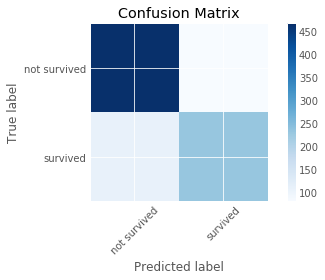

In [12]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    target_names = ['not survived', 'survived']

    tick_marks = np.arange(len(target_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(target_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(target_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()

plot_confusion_matrix(cm)

### テストデータから生存者を推定
#### 演習問題
トレーニングデータと同様に、Kaggleに投稿するテストデータからも生存者を推定しましょう。

#### 解答例

In [13]:
x_test = df_test['Sex']
y_test_pred = x_test.map({'female': 1, 'male': 0}).astype(int)

### Kaggleに投稿するファイルの作成

推定した結果を、Kaggleに投稿するためのCSVファイルを作成します。CSVファイルに記載する必要のあるデータはPassengerIdとSurvived（生存者の推定値）です。pandasで投稿データ用のDataFrameを作成し、[to_csv](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.to_csv.html)を使ってCSV形式で保存します。

In [14]:
df_kaggle = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived':np.array(y_test_pred)})
df_kaggle.to_csv('kaggle_gendermodel.csv', index=False)

In [15]:
df_kaggle.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


作成したkaggle_gendermodel.csvを[Kaggle](https://www.kaggle.com/c/titanic-gettingStarted)に投稿し、スコアと順位を確認してみましょう！これで皆さんもKagglerです！

---
## 4. ロジスティック回帰による生存者推定

scikit-learnに実装されている機械学習のアルゴリズムを使うことを学びます。先ずは最も基本的な線形モデルから始めましょう。

### 使用するデータの選択
ジェンダーモデルでは、性別情報だけを使って生存者の推定を行いましたが、正解率を上げるために他の特徴量も使ってみましょう。チュートリアル第一部の解析より、性別は女性で、年齢は若く、乗船クラスのランクが高いほど生存率は高くなることが分かっています。今回はこれを仮説として使います。性別に加えて、年齢（Age）と乗船クラス（Pclass）を特徴量をして選びましょう。

In [16]:
X = df_train[['Age', 'Pclass', 'Sex']]
y = df_train['Survived']

特徴量のデータフレームを確認します。

In [17]:
X.tail()

,Age,Pclass,Sex
886,27.0,2,male
887,19.0,1,female
888,NaN,3,female
889,26.0,1,male
890,32.0,3,male


年齢に欠損値があります。教師データのサイズが十分に大きければ、欠損値を使わなくても問題ありません。今回は教師データがあまり大きくないため、欠損値を埋めて使います。チュートリアル第一部では、欠損値を埋める手法をいくつか紹介しましたが、今回は全体の平均値を使うことにします。

In [18]:
X['AgeFill'] = X['Age'].fillna(X['Age'].mean())
X = X.drop(['Age'], axis=1)

また、性別（Sex）はmaleとfemaleという値が入っていますが、scikit-learnでは、このようなカテゴリー情報を扱うことが出来ません。そのため、female、maleを数値に変換する必要があります。femaleを0、maleを1とし、新しくGenderを作成します。

In [19]:
X['Gender'] = X['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [20]:
X.tail()

,Pclass,Sex,AgeFill,Gender
886,2,male,27.000000,1
887,1,female,19.000000,0
888,3,female,29.699118,0
889,1,male,26.000000,1
890,3,male,32.000000,1


次に、女性（Gender=0）で且つ、乗船クラスのランクが高い（Pclass=1）ほど、生存率が高いという仮説を表す新しい特徴量（Pclass_Gender）を作成します。Pclass_Genderは値が小さいほど生存率が高いことになります。

In [21]:
X['Pclass_Gender'] = X['Pclass'] + X['Gender']

In [22]:
X.tail()

,Pclass,Sex,AgeFill,Gender,Pclass_Gender
886,2,male,27.000000,1,3
887,1,female,19.000000,0,1
888,3,female,29.699118,0,3
889,1,male,26.000000,1,2
890,3,male,32.000000,1,4


今回は特徴量としてPclass_GenderとAgeの2つを使います。不要になった特徴量は、[drop](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.drop.html)で削除します。

In [23]:
X = X.drop(['Pclass', 'Sex', 'Gender'], axis=1)

In [24]:
X.head()

,AgeFill,Pclass_Gender
0,22.0,4
1,38.0,1
2,26.0,3
3,35.0,1
4,35.0,4


データを可視化して「年齢が若く、女性で且つ、乗船クラスのランクが高いほど、生存率が高い」という仮説が正しいか確認してみましょう。横軸が年齢、縦軸がPclass_Genderを表します。

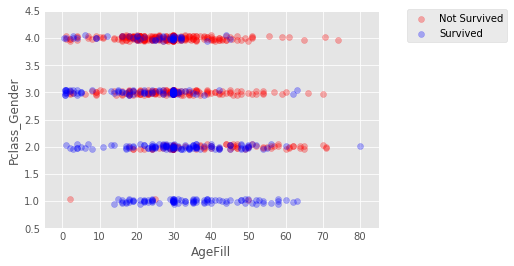

In [25]:
np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = y[y==0].index
index_notsurvived = y[y==1].index

fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(X.loc[index_survived, 'AgeFill'],
                X.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(X.loc[index_notsurvived, 'AgeFill'],
                X.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))
plt.show()

いかがでしょうか？仮説は正しく、グラフの左下で生存者が多くなっていますね。

### トレーニングデータの分割
機械学習では、学習にデータをすべて使ってしまうと、モデルを正しく評価出来ません。そこで、データを学習用と評価用の2つに分割します。分割はscikit-learnの[train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)で簡単に行うことが出来ます。ここでは、データの80%を学習用、20%を評価用として分割します。x_val、y_valのvalはvalidationの略です。

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

In [27]:
X_train

,AgeFill,Pclass_Gender
301,29.699118,4
309,30.000000,1
516,34.000000,2
120,21.000000,3
570,62.000000,3
730,29.000000,1
228,18.000000,3
563,29.699118,4
311,18.000000,1
613,29.699118,4


In [28]:
print('Num of Training Samples: {}'.format(len(X_train)))
print('Num of Validation Samples: {}'.format(len(X_val)))

Num of Training Samples: 712
Num of Validation Samples: 179


### ロジスティック回帰による推定
線形モデルである[ロジスティック回帰（LogisticRegression）](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)を使います。clfは分類器を意味するclassifierの略です。

In [29]:
clf = LogisticRegression()

先ほど分割した学習用データを使います。

In [30]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

これで、学習は完了です。データ数が少ないため、あっという間に終わります。<br>次に生存者の推定をしますが、こちらも簡単に行えます。先ほど分割した学習用データと、評価用データの両方について推定します。

In [31]:
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

結果を評価してみましょう。

In [32]:
print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.774
Accuracy on Validation Set: 0.760


In [33]:
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

[[93 13]
 [30 43]]


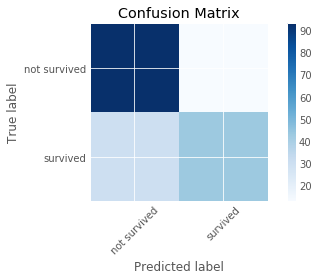

In [34]:
plot_confusion_matrix(cm)

ロジスティック回帰はどのような役割を確認しましょう。matplotlibで可視化します。

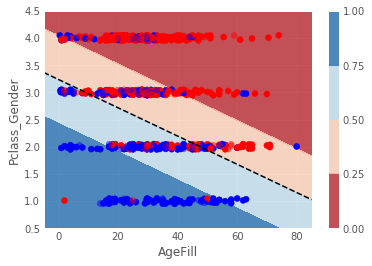

In [35]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0, 5)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.8)
ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1]+(np.random.rand(len(X_train))-0.5)*0.1, c=y_train, cmap=cm_bright)
ax.scatter(X_val.iloc[:, 0], X_val.iloc[:, 1]+(np.random.rand(len(X_val))-0.5)*0.1, c=y_val, cmap=cm_bright, alpha=0.5)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
fig.colorbar(contour)

x1 = xmin
x2 = xmax
y1 = -1*(clf.intercept_[0]+clf.coef_[0][0]*xmin)/clf.coef_[0][1]
y2 = -1*(clf.intercept_[0]+clf.coef_[0][0]*xmax)/clf.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

plt.show()

ロジスティック回帰は与えられた特徴量に基づいて、乗客が生存したか、生存しなかったかの境界（グラフの点線）を判断しています。これの境界はHyperplane（超平面）または、Decision Boundary（決定境界）と呼ばれます。機械学習の分類問題の目的は、この境界を求めることとも言えます。アルゴリズムによって、この境界の求め方が異なり、結果も異なります。機械学習の様々な分野で広く使われいている[SVM（Support Vector Machines）](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)と比較してみましょう。アルゴリズムの詳細の説明は省略します。

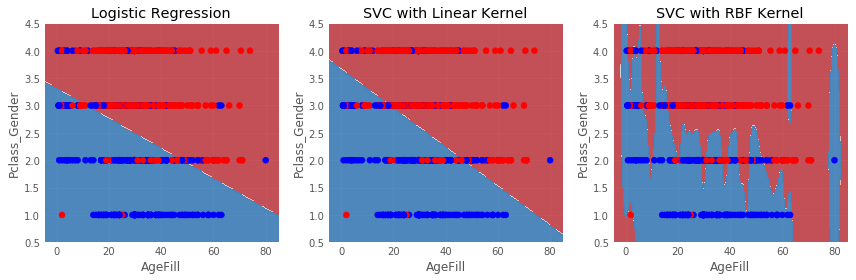

In [36]:
clf_log = LogisticRegression()
clf_svc_lin = SVC(kernel='linear', probability=True)
clf_svc_rbf = SVC(kernel='rbf', probability=True)
titles = ['Logistic Regression', 'SVC with Linear Kernel', 'SVC with RBF Kernel',]

h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

fig, axes = plt.subplots(1, 3, figsize=(12,4))
levels = np.linspace(0, 1.0, 5)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
for i, clf in enumerate((clf_log, clf_svc_lin, clf_svc_rbf)):
    clf.fit(X, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[i].contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.8)
    axes[i].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('AgeFill')
    axes[i].set_ylabel('Pclass_Gender')
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_ylim(ymin, ymax)
    fig.tight_layout()

### 過学習（Overfitting）
上のグラフから分かるように、SVC with RBF Kernelは複雑な形状の境界が作れますが、これが必ずしも良いわけではありません。理由は、学習用データに対して性能が高くなり、評価用データに対して性能が低くなる場合があるためです。これを過学習（Overfitting）と呼びます。アルゴリズムが複雑になるほど、注意が必要です。

In [37]:
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.826
Accuracy on Validation Set: 0.743


---
## 5. 交差検証（クロスバリデーション）
#### 演習問題
モデルを評価するために、データを学習用と評価用の2つに分割することを説明しましたが、データが変わっても結果は同じでしょうか？train_test_splitで指定するrandom_stateの値を変化させて実際に確認してみましょう。

#### 解答例

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=33)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Test Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.784
Accuracy on Test Set: 0.743


どの部分を教師データにするかによって結果は異なります。この課題を解決する方法として交差検証（クロスバリデーション、Cross-validation）という手法があります。ここでは、K-分割交差検証（K-fold cross-validation）を使いましょう。K-分割交差検証は、データをK個に分割し、そのうちK-1個のデータセットを学習に、K個のデータを訓練に用いるということをK回繰り返し、得られた結果の平均を得るというものです。例えば、5-fold cross-validationの場合、5つのデータセットを作成します。各データセットには20%のサンプルが含まれていることになりますが、これを利用し、80%のサンプルで学習、20%のサンプルで評価するということを5回繰り返します。

In [39]:
Image(url='http://scott.fortmann-roe.com/docs/docs/MeasuringError/crossvalidation.png')

scikit-learnでも[cross_validation](http://scikit-learn.org/stable/modules/cross_validation.html)として実装されています。K-分割交差検証を関数として定義し、実行してみましょう。

In [40]:
def cross_val(clf, X, y, random_state=0):
    cv = KFold(len(y), shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=cv)
    return scores

In [41]:
clf = LogisticRegression()
scores = cross_val(clf, X, y)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

Scores: [ 1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.
  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.
  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

### 3つ以上の特徴量を使う
3つ以上の特徴量を使う場合も同様に学習を行い、Hyperplaneを求めることが出来ます。

In [42]:
X = df_train[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]
y = df_train['Survived']
X_test = df_test[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]

In [43]:
X.tail()

,Age,Pclass,Sex,SibSp,Parch,Embarked
886,27.0,2,male,0,0,S
887,19.0,1,female,0,0,S
888,NaN,3,female,1,2,S
889,26.0,1,male,0,0,C
890,32.0,3,male,0,0,Q


#### 演習問題
前回と同様に、年齢の欠損値を平均値で埋め、性別を数値化しましょう。

#### 解答例

In [44]:
X['AgeFill'] = X['Age'].fillna(X['Age'].mean())
X_test['AgeFill'] = X_test['Age'].fillna(X['Age'].mean())

X = X.drop(['Age'], axis=1)
X_test = X_test.drop(['Age'], axis=1)

性別の数値化にはscikit-learnの[LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)を使うことも出来ます。

In [45]:
le = LabelEncoder()
le.fit(X['Sex'])
X['Gender'] = le.transform(X['Sex'])
X_test['Gender'] = le.transform(X_test['Sex'])
classes = {gender: i for (i, gender) in enumerate(le.classes_)}
print(classes)

{'male': 1, 'female': 0}


In [46]:
X.tail()

,Pclass,Sex,SibSp,Parch,Embarked,AgeFill,Gender
886,2,male,0,0,S,27.000000,1
887,1,female,0,0,S,19.000000,0
888,3,female,1,2,S,29.699118,0
889,1,male,0,0,C,26.000000,1
890,3,male,0,0,Q,32.000000,1


### One-hot Encoding

性別（Sex）と同様に乗船地（Embarked）もそのままでは使えないため、数値化する必要がありますが、対象となるのはS、C、Qの3種類です。このような場合は、One-hot Encording、またはOne-of-K Encordingという手法を使って、新たな特徴量を作ります。pandasの[get_dummies](http://pandas.pydata.org/pandas-docs/version/0.15.2/generated/pandas.get_dummies.html)を使います。

In [47]:
X = X.join(pd.get_dummies(X['Embarked'], prefix='Embarked'))
X_test = X_test.join(pd.get_dummies(X['Embarked'], prefix='Embarked'))

In [48]:
X.tail()

,Pclass,Sex,SibSp,Parch,Embarked,AgeFill,Gender,Embarked_C,Embarked_Q,Embarked_S
886,2,male,0,0,S,27.000000,1,0,0,1
887,1,female,0,0,S,19.000000,0,0,0,1
888,3,female,1,2,S,29.699118,0,0,0,1
889,1,male,0,0,C,26.000000,1,1,0,0
890,3,male,0,0,Q,32.000000,1,0,1,0


不要な特徴量は削除しましょう。

In [49]:
X = X.drop(['Sex', 'Embarked'], axis=1)
X_test = X_test.drop(['Sex', 'Embarked'], axis=1)

ロジスティック回帰＋交差検証で評価します。

In [50]:
clf = LogisticRegression()
scores = cross_val(clf, X, y)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

Scores: [ 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

スコアが改善しました！

---
## 6. 決定木（Decision Tree）による生存者推定

決定木は、機械学習の手法の中でも非常によく用いられるものの一つです。分類を決定づけた要因を木構造で説明することが出来るため、非常に分かりやすいという特徴があります。

In [51]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=2)
scores = cross_val(clf, X, y, 5)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

Scores: [ 1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.
  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.
  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.
  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.
  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1

In [52]:
Image(url='https://raw.githubusercontent.com/PyDataTokyo/pydata-tokyo-tutorial-1/master/images/titanic_decision_tree.png')

#### 演習問題
決定木のパラメータを変えて、スコアを比較してみましょう。

#### 解答例

In [53]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2)
scores = cross_val(clf, X, y, 5)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

Scores: [ 1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1

---
## 7. グリッドサーチ
グリッドサーチは、分類器のパラメータを指定した範囲で変化させ、最もスコアの高いパラメータの組合せを探してくれる便利な機能です。

In [54]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=2)

param_grid = {'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]}
cv = KFold(len(y), shuffle=True, random_state=0)

grid_search = GridSearchCV(clf, param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 891 folds for each of 16 candidates, totalling 14256 fits


[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 10192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 14256 out of 14256 | elapsed:   31.3s finished


GridSearchCV(cv=KFold(n_splits=891, random_state=0, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

ベストなスコアとパラメータの組合せを確認します。

In [55]:
print('Scores: {:.3f}'.format(grid_search.best_score_))
print('Best Parameter Choice:', grid_search.best_params_)

Scores: 0.829
Best Parameter Choice: {'max_depth': 4, 'min_samples_leaf': 3}


全ての結果を確認することも出来ます。

In [56]:
grid_search.grid_scores_

/Users/iktakahiro/miniconda3/envs/env1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.68799, std: 0.46331, params: {'max_depth': 2, 'min_samples_leaf': 2},
 mean: 0.68799, std: 0.46331, params: {'max_depth': 2, 'min_samples_leaf': 3},
 mean: 0.68799, std: 0.46331, params: {'max_depth': 2, 'min_samples_leaf': 4},
 mean: 0.68799, std: 0.46331, params: {'max_depth': 2, 'min_samples_leaf': 5},
 mean: 0.82267, std: 0.38195, params: {'max_depth': 3, 'min_samples_leaf': 2},
 mean: 0.82492, std: 0.38004, params: {'max_depth': 3, 'min_samples_leaf': 3},
 mean: 0.82492, std: 0.38004, params: {'max_depth': 3, 'min_samples_leaf': 4},
 mean: 0.82604, std: 0.37908, params: {'max_depth': 3, 'min_samples_leaf': 5},
 mean: 0.82716, std: 0.37811, params: {'max_depth': 4, 'min_samples_leaf': 2},
 mean: 0.82941, std: 0.37615, params: {'max_depth': 4, 'min_samples_leaf': 3},
 mean: 0.82379, std: 0.38100, params: {'max_depth': 4, 'min_samples_leaf': 4},
 mean: 0.80808, std: 0.39381, params: {'max_depth': 4, 'min_samples_leaf': 5},
 mean: 0.80135, std: 0.39899, params: {'max_depth': 

/Users/iktakahiro/miniconda3/envs/env1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


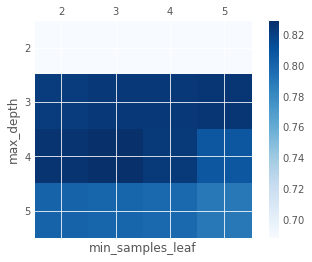

In [57]:
scores = [x[1] for x in grid_search.grid_scores_]
scores = np.array(scores).reshape(4, 4)

fig, ax = plt.subplots()
cm = plt.cm.Blues
mat = ax.matshow(scores, cmap=cm)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('max_depth')
ax.set_xticklabels(['']+param_grid['min_samples_leaf'])
ax.set_yticklabels(['']+param_grid['max_depth'])
fig.colorbar(mat)
plt.show()

/Users/iktakahiro/miniconda3/envs/env1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


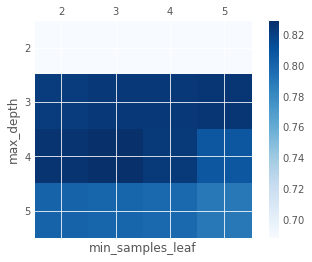

In [58]:
scores = [x[1] for x in grid_search.grid_scores_]
scores = np.array(scores).reshape(4, 4)

fig, ax = plt.subplots()
cm = plt.cm.Blues
mat = ax.matshow(scores, cmap=cm)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('max_depth')
ax.set_xticklabels(['']+param_grid['min_samples_leaf'])
ax.set_yticklabels(['']+param_grid['max_depth'])
fig.colorbar(mat)
plt.show()

/Users/iktakahiro/miniconda3/envs/env1/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


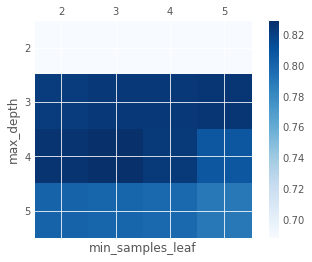

In [59]:
scores = [x[1] for x in grid_search.grid_scores_]
scores = np.array(scores).reshape(4, 4)

fig, ax = plt.subplots()
cm = plt.cm.Blues
mat = ax.matshow(scores, cmap=cm)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('max_depth')
ax.set_xticklabels(['']+param_grid['min_samples_leaf'])
ax.set_yticklabels(['']+param_grid['max_depth'])
fig.colorbar(mat)
plt.show()

ベストなパラメータの組合せで推定を行います。

In [60]:
y_test_pred = grid_search.predict(X_test)

Kaggleに投稿するためのCSVファイルを作成し、結果を確認してみましょう。

In [61]:
df_kaggle = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived':np.array(y_test_pred)})
df_kaggle.to_csv('kaggle_decisiontree.csv', index=False)

チュートリアル第二部はこれで終了です。ここで学んだことを活かして、さらに高いスコアを目指してください！

## 参考文献

- [Building Machine Learning Systems with Python](https://www.packtpub.com/big-data-and-business-intelligence/building-machine-learning-systems-python)
- [Learning scikit-learn: Machine Learning in Python](https://www.packtpub.com/big-data-and-business-intelligence/learning-scikit-learn-machine-learning-python)
- [Tutorial on scikit-learn and IPython for parallel machine learning](https://github.com/ogrisel/parallel_ml_tutorial)
- [PyData NYC 2014 tutorial on the more advanced features of scikit-learn](https://github.com/amueller/pydata-nyc-advanced-sklearn)